There are 4 steps in R-CNN. They are as follows :
- Pass the image through selective search and generate region proposal.
- Calculate IOU (intersection over union) on proposed region with ground truth data and add label to the proposed regions.
- Do transfer learning using the proposed regions with the labels.
- Pass the test image to selective search and then pass the first 2000 proposed regions from the trained model and predict the class of those regions.

# Load dataset

In [1]:
import os
from google.colab import drive
drive.mount('/content/drive')

path = "/content/drive/My Drive/RCNN-master/"

os.chdir(path)
os.listdir(path)

Mounted at /content/drive


['Images.zip',
 'RCNN.ipynb',
 'README.md',
 'parse.py',
 'LICENSE',
 'Airplanes_Annotations.zip']

In [2]:
import os,cv2,keras
# use cv2 to perform selective search on the images 
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf

In [3]:
!pip install opencv-contrib-python

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


# Data

In [ ]:
!unzip Images.zip

In [ ]:
!unzip Airplanes_Annotations.zip

In [6]:
path = "Images"
annot = "Airplanes_Annotations"

airplane_095.jpg


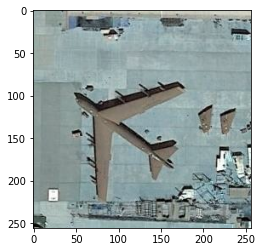

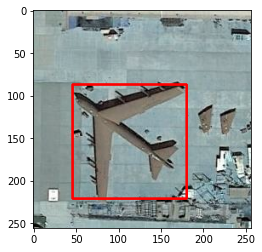

In [7]:
for e,i in enumerate(os.listdir(annot)):
    if e < 10:
        filename = i.split(".")[0]+".jpg"
        print(filename)
        img = cv2.imread(os.path.join(path,filename))
        df = pd.read_csv(os.path.join(annot,i))
        plt.imshow(img)
        for row in df.iterrows():
            x1 = int(row[1][0].split(" ")[0])
            y1 = int(row[1][0].split(" ")[1])
            x2 = int(row[1][0].split(" ")[2])
            y2 = int(row[1][0].split(" ")[3])
            cv2.rectangle(img,(x1,y1),(x2,y2),(255,0,0), 2)
        plt.figure()
        plt.imshow(img)
        break

selective search

In [8]:
cv2.setUseOptimized(True);
 # 使用默认参数创建一个选择性搜索的分割对象

ss = cv2.ximgproc.segmentation.createSelectiveSearchSegmentation()

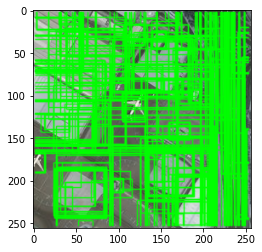

In [9]:
im = cv2.imread(os.path.join(path,"42850.jpg"))
    # set input image on which we will run segmentation    
ss.setBaseImage(im)
ss.switchToSelectiveSearchFast()
    # 运行选择性搜索算法，返回他们的可能边框

rects = ss.process()
imOut = im.copy()
for i, rect in (enumerate(rects)):
    x, y, w, h = rect
#     print(x,y,w,h)
#     imOut = imOut[x:x+w,y:y+h]
    cv2.rectangle(imOut, (x, y), (x+w, y+h), (0, 255, 0), 1, cv2.LINE_AA)
# plt.figure()
plt.imshow(imOut)

IoU = Area of Overlap / Area of Union

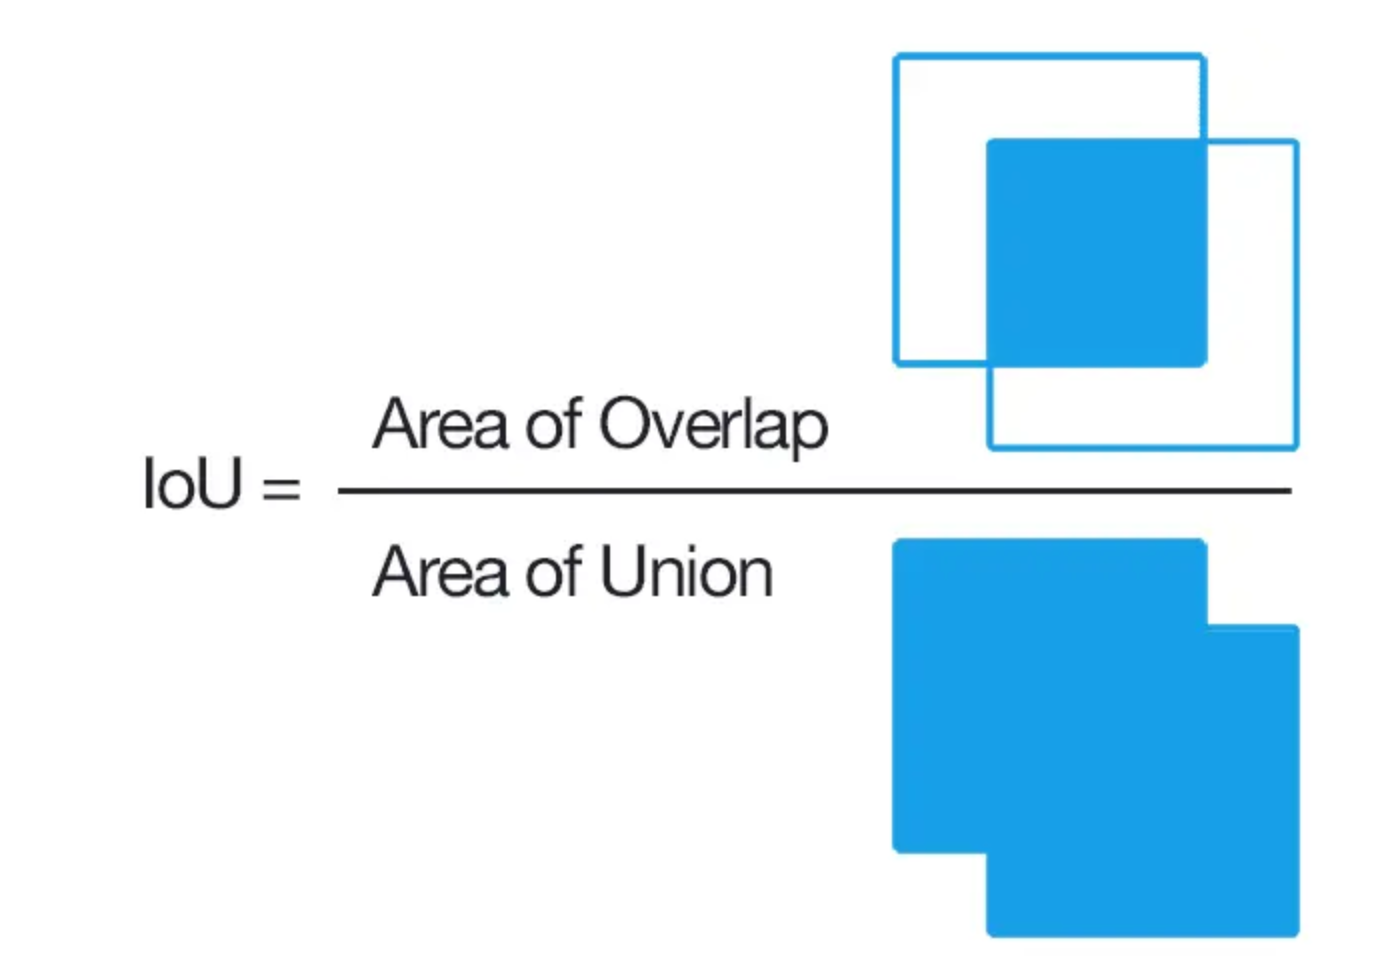

In [11]:
train_images=[]
train_labels=[]
def get_iou(bb1, bb2):
    assert bb1['x1'] < bb1['x2']
    assert bb1['y1'] < bb1['y2']
    assert bb2['x1'] < bb2['x2']
    assert bb2['y1'] < bb2['y2']

    x_left = max(bb1['x1'], bb2['x1'])
    y_top = max(bb1['y1'], bb2['y1'])
    x_right = min(bb1['x2'], bb2['x2'])
    y_bottom = min(bb1['y2'], bb2['y2'])

    if x_right < x_left or y_bottom < y_top:
        return 0.0

    intersection_area = (x_right - x_left) * (y_bottom - y_top)

    bb1_area = (bb1['x2'] - bb1['x1']) * (bb1['y2'] - bb1['y1'])
    bb2_area = (bb2['x2'] - bb2['x1']) * (bb2['y2'] - bb2['y1'])

    iou = intersection_area / float(bb1_area + bb2_area - intersection_area)
    assert iou >= 0.0
    assert iou <= 1.0
    return iou

In [12]:
ss = cv2.ximgproc.segmentation.createSelectiveSearchSegmentation()

1.Loop over the image folder and set each image one by one as the base for selective search using code ss.setBaseImage(image)
2.Initialising fast selective search and getting proposed regions using using code ss.switchToSelectiveSearchFast() and ssresults = ss.process()
3.Iterating over all the first 2000 results passed by selective search and calculating IOU of the proposed region and annotated region using the get_iou() function created above.
4.Now as one image can many negative sample (i.e. background) and just some positive sample (i.e. airplane) so we need to make sure that we have good proportion of both positive and negative sample to train our model. Therefore we have set that we will collect maximum of 30 negative sample (i.e. background) and positive sample (i.e. airplane) from one image.

In [13]:
for e,i in enumerate(os.listdir(annot)):
    try:
        if i.startswith("airplane"):
            filename = i.split(".")[0]+".jpg"
            print(e,filename)
            image = cv2.imread(os.path.join(path,filename))
            df = pd.read_csv(os.path.join(annot,i))
            gtvalues=[]
            for row in df.iterrows():
                x1 = int(row[1][0].split(" ")[0])
                y1 = int(row[1][0].split(" ")[1])
                x2 = int(row[1][0].split(" ")[2])
                y2 = int(row[1][0].split(" ")[3])
                gtvalues.append({"x1":x1,"x2":x2,"y1":y1,"y2":y2})
            ss.setBaseImage(image)
            ss.switchToSelectiveSearchFast()
            ssresults = ss.process()
            imout = image.copy()
            counter = 0
            falsecounter = 0
            flag = 0
            fflag = 0
            bflag = 0
            for e,result in enumerate(ssresults):
                if e < 2000 and flag == 0:
                    for gtval in gtvalues:
                        x,y,w,h = result
                        iou = get_iou(gtval,{"x1":x,"x2":x+w,"y1":y,"y2":y+h})
                        if counter < 30:
                            if iou > 0.70:
                                timage = imout[y:y+h,x:x+w]
                                resized = cv2.resize(timage, (224,224), interpolation = cv2.INTER_AREA)
                                train_images.append(resized)
                                train_labels.append(1)
                                counter += 1
                        else :
                            fflag =1
                        if falsecounter <30:
                            if iou < 0.3:
                                timage = imout[y:y+h,x:x+w]
                                resized = cv2.resize(timage, (224,224), interpolation = cv2.INTER_AREA)
                                train_images.append(resized)
                                train_labels.append(0)
                                falsecounter += 1
                        else :
                            bflag = 1
                    if fflag == 1 and bflag == 1:
                        print("inside")
                        flag = 1
    except Exception as e:
        print(e)
        print("error in "+filename)
        continue

0 airplane_095.jpg
1 airplane_094.jpg
2 airplane_093.jpg
3 airplane_092.jpg
4 airplane_091.jpg
5 airplane_090.jpg
6 airplane_089.jpg
7 airplane_088.jpg
8 airplane_087.jpg
9 airplane_086.jpg
10 airplane_085.jpg
inside
11 airplane_084.jpg
12 airplane_083.jpg
inside
13 airplane_082.jpg
14 airplane_081.jpg
15 airplane_080.jpg
16 airplane_079.jpg
17 airplane_078.jpg
18 airplane_077.jpg
19 airplane_076.jpg
20 airplane_075.jpg
inside
21 airplane_074.jpg
22 airplane_073.jpg
23 airplane_072.jpg
24 airplane_070.jpg
25 airplane_067.jpg
26 airplane_065.jpg
27 airplane_062.jpg
inside
28 airplane_059.jpg
29 airplane_057.jpg
30 airplane_054.jpg
31 airplane_051.jpg
32 airplane_049.jpg
33 airplane_046.jpg
34 airplane_043.jpg
35 airplane_041.jpg
inside
36 airplane_038.jpg
37 airplane_035.jpg
38 airplane_033.jpg
39 airplane_030.jpg
40 airplane_027.jpg
41 airplane_025.jpg
42 airplane_022.jpg
43 airplane_019.jpg
44 airplane_017.jpg
45 airplane_014.jpg
46 airplane_011.jpg
47 airplane_009.jpg
48 airplane_006

In [14]:
import numpy as np

In [15]:
X_new = np.array(train_images)
y_new = np.array(train_labels)

In [16]:
X_new.shape

(30229, 224, 224, 3)

In [17]:
from keras.layers import Dense
from keras import Model
from keras import optimizers
from keras.preprocessing.image import ImageDataGenerator
from keras.applications.vgg16 import VGG16

Now we will do transfer learning on the imagenet weight. We will import VGG16 model and also put the imagenet weight in the model. To learn more about transfer learning you can refer to the article on link below.

In [18]:
vggmodel = VGG16(weights='imagenet', include_top=True)
vggmodel.summary()

553476096/553467096 [==============================] - 6s 0us/step
Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                            

In this part in the loop we are freezing the first 15 layers of the model. After that we are taking out the second last layer of the model and then adding a 2 unit softmax dense layer as we have just 2 classes to predict i.e. foreground or background. After that we are compiling the model using Adam optimizer with learning rate of 0.001. We are using categorical_crossentropy as loss since the output of the model is categorical. Finally the summary of the model will is printed using model_final.summary().

In [24]:
from keras.layers import Dense
from keras import Model
from keras import optimizers
from keras.preprocessing.image import ImageDataGenerator
from keras.applications.vgg16 import VGG16

In [25]:
for layers in (vggmodel.layers)[:15]:
    print(layers)
    layers.trainable = False

In [28]:
X= vggmodel.layers[-2].output
predictions = Dense(2, activation="softmax")(X)
model_final = Model(vggmodel.input, predictions)
opt = tf.keras.optimizers.Adam(lr=0.0001)
model_final.compile(loss = keras.losses.categorical_crossentropy, optimizer = opt, metrics=["accuracy"])
model_final.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0   

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


 flatten (Flatten)           (None, 25088)             0         
                                                                 
 fc1 (Dense)                 (None, 4096)              102764544 
                                                                 
 fc2 (Dense)                 (None, 4096)              16781312  
                                                                 
 dense_3 (Dense)             (None, 2)                 8194      
                                                                 
Total params: 134,268,738
Trainable params: 126,633,474
Non-trainable params: 7,635,264
_________________________________________________________________


In [29]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelBinarizer

After creating the model now we need to split the dataset into train and test set. Before that we need to one-hot encode the label. For that we are using MyLabelBinarizer() and encoding the dataset. Then we are splitting the dataset using train_test_split from sklearn. We are keeping 10% of the dataset as test set and 90% as training set.

In [31]:
class MyLabelBinarizer(LabelBinarizer):
    def transform(self, y):
        Y = super().transform(y)
        if self.y_type_ == 'binary':
            return np.hstack((Y, 1-Y))
        else:
            return Y
    def inverse_transform(self, Y, threshold=None):
        if self.y_type_ == 'binary':
            return super().inverse_transform(Y[:, 0], threshold)
        else:
            return super().inverse_transform(Y, threshold)

In [ ]:
lenc = MyLabelBinarizer()
Y =  lenc.fit_transform(y_new)
X_train, X_test , y_train, y_test = train_test_split(X_new,Y,test_size=0.10)
print(X_train.shape,X_test.shape,y_train.shape,y_test.shape)

Now we will use Keras ImageDataGenerator to pass the dataset to the model. We will do some augmentation on the dataset like horizontal flip, vertical flip and rotation to increase the dataset.

In [ ]:
trdata = ImageDataGenerator(horizontal_flip=True, vertical_flip=True, rotation_range=90)
traindata = trdata.flow(x=X_train, y=y_train)
tsdata = ImageDataGenerator(horizontal_flip=True, vertical_flip=True, rotation_range=90)
testdata = tsdata.flow(x=X_test, y=y_test)

In [ ]:
from keras.callbacks import ModelCheckpoint, EarlyStopping
checkpoint = ModelCheckpoint("ieeercnn_vgg16_1.h5", monitor='val_loss', verbose=1, save_best_only=True, save_weights_only=False, mode='auto', period=1)
early = EarlyStopping(monitor='val_loss', min_delta=0, patience=100, verbose=1, mode='auto')
hist = model_final.fit_generator(generator= traindata, steps_per_epoch= 10, epochs= 1000, validation_data= testdata, validation_steps=2, callbacks=[checkpoint,early])


In [ ]:
import matplotlib.pyplot as plt
# plt.plot(hist.history["acc"])
# plt.plot(hist.history['val_acc'])
plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.title("model loss")
plt.ylabel("Loss")
plt.xlabel("Epoch")
plt.legend(["Loss","Validation Loss"])
plt.show()
plt.savefig('chart loss.png')

In [ ]:
im = X_test[1600]
plt.imshow(im)
img = np.expand_dims(im, axis=0)
out= model_final.predict(img)
if out[0][0] > out[0][1]:
    print("plane")
else:
    print("not plane")

Now we start the training of the model using fit_generator.


In [ ]:
z=0
for e,i in enumerate(os.listdir(path)):
    if i.startswith("4"):
        z += 1
        img = cv2.imread(os.path.join(path,i))
        ss.setBaseImage(img)
        ss.switchToSelectiveSearchFast()
        ssresults = ss.process()
        imout = img.copy()
        for e,result in enumerate(ssresults):
            if e < 2000:
                x,y,w,h = result
                timage = imout[y:y+h,x:x+w]
                resized = cv2.resize(timage, (224,224), interpolation = cv2.INTER_AREA)
                img = np.expand_dims(resized, axis=0)
                out= model_final.predict(img)
                if out[0][0] > 0.65:
                    cv2.rectangle(imout, (x, y), (x+w, y+h), (0, 255, 0), 1, cv2.LINE_AA)
        plt.figure()
        plt.imshow(imout)